importando bibliotecas necessárias 

In [193]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

Parâmetros do problema

In [194]:
L = 10.0          # Comprimento da viga 
P = 10000.0       # Carga concentrada 
E = 200e9         # Módulo de elasticidade 
I = 5e-5          # Momento de inércia 
N = 10            # Número de nós

Definindo solver

In [195]:
def gauss_seidel(A, b, max_iter=10000, tol=1e-6):
    
    n = len(b)
    y = np.zeros(n)
    
    for k in range(max_iter):
        y_old = y.copy()
        
        for i in range(n):
            soma1 = np.dot(A[i, :i], y[:i])
            soma2 = np.dot(A[i, i+1:], y_old[i+1:])
            y[i] = (b[i] - soma1 - soma2) / A[i, i]
            
        erro = np.linalg.norm(y - y_old, ord=np.inf)
        if erro < tol:
            
            return y
            
    print("Aviso: Número máximo de iterações atingido.")
    return y

Equação do problema

In [196]:
def deflexao(L, P, E, I, N):
    dx = L / (N - 1)
    x = np.linspace(0, L, N)

    # --- Monta o sistema APENAS para os nós internos ---
    num_incognitas = N - 2
    A = np.zeros((num_incognitas, num_incognitas))
    b = np.zeros(num_incognitas)

    # Vetor de momento fletor (calculado para todos os pontos)
    M = np.zeros(N)
    for i in range(N):
        if x[i] < L/2:
            M[i] = (P/2) * x[i]
        else:
            M[i] = (P/2) * (L - x[i])

    # Preenche a matriz A e o vetor b para os nós internos
    for i in range(num_incognitas):
        A[i, i] = -2.0
        if i > 0:
            A[i, i-1] = 1.0
        if i < num_incognitas - 1:
            A[i, i+1] = 1.0
        
        # O índice M[i+1] corresponde ao primeiro nó interno
        b[i] = (M[i+1] * dx**2) / (E * I)

    # --- Resolve o sistema com Gauss-Seidel ---
    y_internos = gauss_seidel(A, b)

    # --- Monta a solução final com as condições de contorno y(0)=0 e y(L)=0 ---
    y = np.zeros(N)
    y[1:N-1] = y_internos
    deflexao_viga_max = np.min(y)
    deflexao_viga_min = np.max(y)

    return x, y, deflexao_viga_max, deflexao_viga_min

Execução das funçôes

In [197]:
resultados_malha = {}
x, y, *_ = deflexao(L, P, E, I, N)
np.array_equal(x, y)
resultados_malha[N] = {
    'N': N,
    'x': x,
    'y': y

}
df=pd.DataFrame(resultados_malha).T
df2=df.explode(['x', 'y']).reset_index(drop=True)
df2

,N,x,y
0,10,0.0,0.0
1,10,1.111111,-0.006856
2,10,2.222222,-0.013027
3,10,3.333333,-0.017826
4,10,4.444444,-0.020569
5,10,5.555556,-0.02057
6,10,6.666667,-0.017827
7,10,7.777778,-0.013028
8,10,8.888889,-0.006857
9,10,10.0,0.0


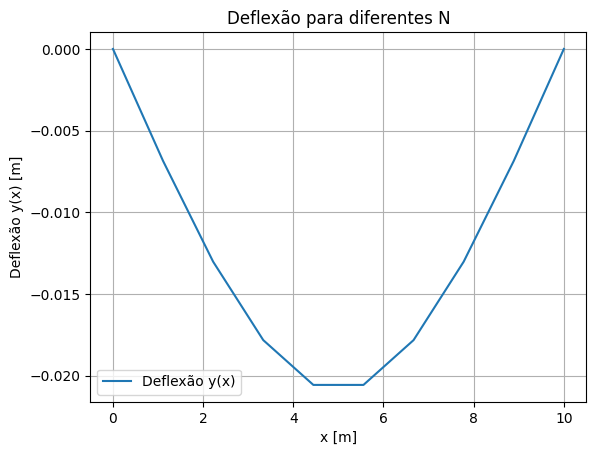

In [198]:
plt.plot(x, y, label="Deflexão y(x)")
plt.xlabel("x [m]")
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão para diferentes N")
plt.grid()
plt.legend()
plt.show()

Estudo do refinamento da malha

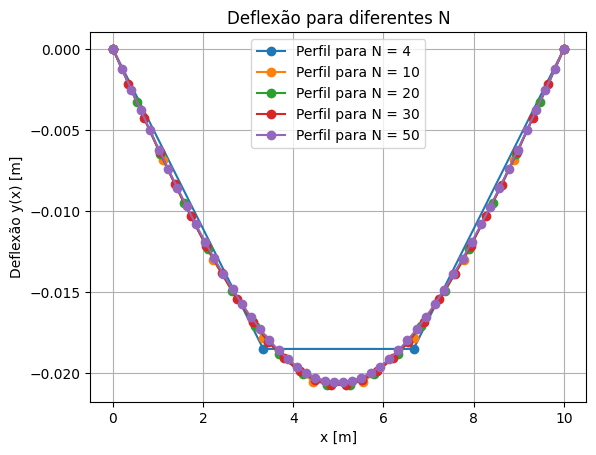

In [199]:
L = 10.0
P = 10000.0
E = 200e9
I = 5e-5
resultados_malha = {}
marcadores = {'x': 'o', 'y': 's', 'z': '^'}

for i in [4,10,20,30,50]:
    x, y, *_ = deflexao(L, P, E, I, i)
    plt.plot(x, y, label=f'Perfil para N = {i}', marker=marcadores['x'])
    resultados_malha[i] = (x, y)

plt.xlabel("x [m]")
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão para diferentes N")
plt.grid()
plt.legend()
plt.show()

In [200]:
# Criando DataFrame a partir de resultados_malha (dict: N -> (x_array, y_array))
rows = []
for N_key, (x_arr, y_arr) in sorted(resultados_malha.items()):
	# índice da maior deflexão (mais negativa) e da menor (mais próxima de zero)
	idx_max_def = int(np.argmin(y_arr))   # posição da deflexão máxima (valor mínimo de y)
	idx_min_def = int(np.argmax(y_arr))   # posição da deflexão mínima (valor máximo de y)
	rows.append({
		'N': int(N_key),
		'x_max': float(x_arr[idx_max_def]),
		'deflexao_max': float(y_arr[idx_max_def]),
		'x_min': float(x_arr[idx_min_def]),
		'deflexao_min': float(y_arr[idx_min_def]),
	})

df_deflexoes = pd.DataFrame(rows)

# Reordenar colunas para legibilidade
df_deflexoes = df_deflexoes[['N', 'x_max', 'deflexao_max', 'x_min', 'deflexao_min']]

# Mostra o DataFrame e salva em CSV
print(df_deflexoes.to_string(index=False))

csv_filename = 'deflexoes_por_N.csv'
df_deflexoes.to_csv(csv_filename, index=False, sep='|', float_format='%.6e')
print(f"Arquivo salvo: {csv_filename}")

 N    x_max  deflexao_max  x_min  deflexao_min
 4 6.666667     -0.018518    0.0           0.0
10 5.555556     -0.020570    0.0           0.0
20 5.263158     -0.020741    0.0           0.0
30 5.172414     -0.020725    0.0           0.0
50 5.102041     -0.020583    0.0           0.0
Arquivo salvo: deflexoes_por_N.csv


In [201]:
timeit_results = {}
for N in [4,10, 20, 30, 50]:
    start_time = time.time()
    x, y, *_ = deflexao(L, P, E, I, N)
    end_time = time.time()
    timeit_results[N] = end_time - start_time
    print(f"N={N}: Tempo de execução = {timeit_results[N]:.6f} segundos")

N=4: Tempo de execução = 0.000502 segundos
N=10: Tempo de execução = 0.004761 segundos
N=20: Tempo de execução = 0.019047 segundos
N=30: Tempo de execução = 0.051589 segundos
N=50: Tempo de execução = 0.192123 segundos


In [202]:
uni=pd.DataFrame.from_dict(timeit_results,orient='index',columns=['Tempo (s)'])
uni.index.name='N'
uni

,Tempo (s)
N,
4,0.000502
10,0.004761
20,0.019047
30,0.051589
50,0.192123


Unir os dataframes 

In [203]:
frames = [uni,df_deflexoes.set_index('N')]
result= pd.concat(frames, axis=1).reset_index()
result

,N,Tempo (s),x_max,deflexao_max,x_min,deflexao_min
0,4,0.000502,6.666667,-0.018518,0.0,0.0
1,10,0.004761,5.555556,-0.020570,0.0,0.0
2,20,0.019047,5.263158,-0.020741,0.0,0.0
3,30,0.051589,5.172414,-0.020725,0.0,0.0
4,50,0.192123,5.102041,-0.020583,0.0,0.0


Estudo de carga

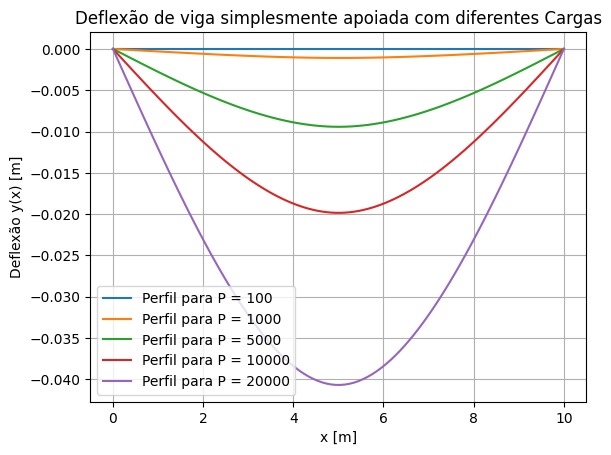

In [204]:
L = 10.0         # Comprimento da viga 
E = 200e9         # Módulo de elasticidade 
I = 5e-5          # Momento de inércia 
N = 100            # Número de nós

for i in [100, 1000, 5000, 10000, 20000]:
    x, y,*_ = deflexao(L, i, E, I, N)
    plt.plot(x, y, label=f'Perfil para P = {i}')

plt.xlabel("x [m]")
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão de viga simplesmente apoiada com diferentes Cargas")
plt.grid()
plt.legend()
plt.show()

Estudo da elastividade

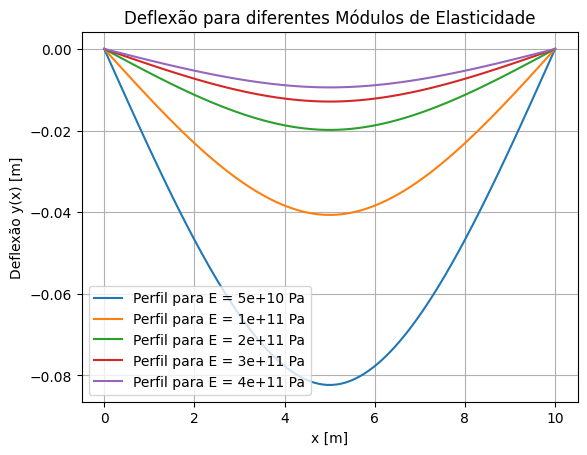

In [205]:
L = 10.0
P = 10000.0
I = 5e-5
N = 100

for i in [50e9, 100e9, 200e9, 300e9, 400e9]:
    x, y, *_ = deflexao(L, P, i, I, N)
    plt.plot(x, y, label=f'Perfil para E = {i:.0e} Pa')

plt.xlabel("x [m]")
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão para diferentes Módulos de Elasticidade")
plt.grid()
plt.legend()
plt.show()

Estudo do Momento de Inércia

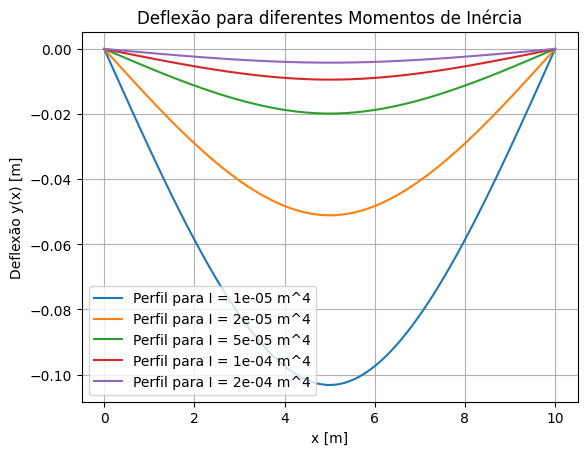

In [206]:

P = 10000.09
N = 100

for i in [1e-5, 2e-5, 5e-5, 1e-4, 2e-4]:
    x, y, *_ = deflexao(L, P, E, i, N)
    plt.plot(x, y, label=f'Perfil para I = {i:.0e} m^4')

plt.xlabel("x [m]")
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão para diferentes Momentos de Inércia")
plt.grid()
plt.legend()
plt.show()

Comparação com o solver pronto da biblioteca Numpy

In [207]:
def deflexao_viga(L, P, E, I, N):
    dx = L / (N - 1)
    x = np.linspace(0, L, N)

    # --- Monta o sistema APENAS para os nós internos ---
    num_incognitas = N - 2
    A = np.zeros((num_incognitas, num_incognitas))
    b = np.zeros(num_incognitas)

    # Vetor de momento fletor (calculado para todos os pontos)
    M = np.zeros(N)
    for i in range(N):
        if x[i] < L/2:
            M[i] = (P/2) * x[i]
        else:
            M[i] = (P/2) * (L - x[i])

    # Preenche a matriz A e o vetor b para os nós internos
    for i in range(num_incognitas):
        A[i, i] = -2.0
        if i > 0:
            A[i, i-1] = 1.0
        if i < num_incognitas - 1:
            A[i, i+1] = 1.0
        
        # O índice M[i+1] corresponde ao primeiro nó interno
        b[i] = (M[i+1] * dx**2) / (E * I)

    # --- Resolve o sistema com Gauss-Seidel ---
    y_internos = np.linalg.solve(A, b)

    # --- Monta a solução final com as condições de contorno y(0)=0 e y(L)=0 ---
    y = np.zeros(N)
    y[1:N-1] = y_internos
    deflexao_viga_max = np.min(y)
    deflexao_viga_min = np.max(y)

    return x, y

In [208]:
L = 10.0
E = 200e9   
I = 5e-5
P = 10000.0
N = 100

In [209]:
resultados_malha = {}
x, y, *_ = deflexao(L, P, E, I, N)
np.array_equal(x, x)
resultados_malha[N] = {
    'N': N,
    'x': x,
    'y': y

}
df=pd.DataFrame(resultados_malha).T
df2=df.explode(['x', 'y']).reset_index(drop=True)
df2

,N,x,y
0,100,0.0,0.0
1,100,0.10101,-0.000599
2,100,0.20202,-0.001198
3,100,0.30303,-0.001795
4,100,0.40404,-0.002391
...,...,...,...
95,100,9.59596,-0.002397
96,100,9.69697,-0.0018
97,100,9.79798,-0.001201
98,100,9.89899,-0.000601


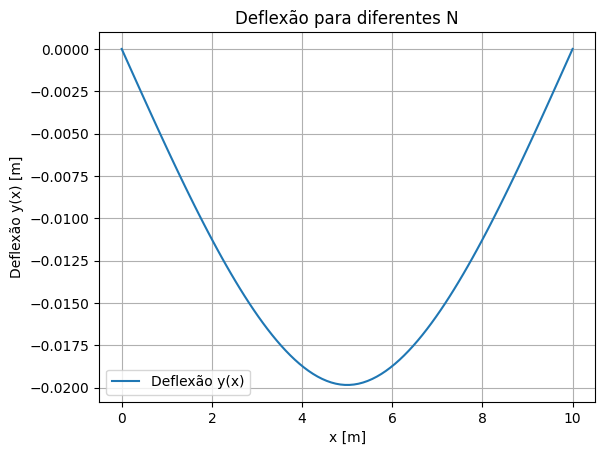

In [210]:
plt.plot(x, y, label="Deflexão y(x)")
plt.xlabel("x [m]") 
plt.ylabel("Deflexão y(x) [m]")
plt.title("Deflexão para diferentes N")
plt.grid()
plt.legend()
plt.show()